In [1]:
import anndata
import numpy as np
import scvelo as scv
import scanpy as sc
import sys
import torch
import os.path
sys.path.append('../')
import velovae as vv

# Load Input Data
We demonstrate the full training pipeline using an example dataset from scVelo.

In [2]:
dataset = "Pancreas"
adata = scv.datasets.pancreas()

Set the folder names for saving model parameters, data and figures.

In [3]:
model_path_base = f"checkpoints/{dataset}"
figure_path_base = f"figures/{dataset}"
data_path_base = f"data/{dataset}"

<br><br><br><br><br>
# Preprocessing
We apply exactly the same preprocessing steps as scVelo.
The "preprocess" function performs the following:
1. Cell and gene filtering based on mRNA counts.
2. Select a number of genes. By default, it applies the selection method in scVelo to pick highly variable genes. The user can also choose to pick a balanced set of genes by setting <b>"selection_method"</b> to "balanced", meaning that all cell types have the same number of marker genes. Besides these two options, the user can also input a custom list of genes via the argument "genes_retain".
3. Compute a KNN graph based on PCA and average the count data across k neighbors. Dimension of PCA can be set via the argument <b>"npc"</b>. The user can also set the number of neighbors via <b>"n_neighbors"</b>.
4. Optionally performs clustering when <b>"perform_clustering"</b> is set to "True".
5. Optionally add informative time prior if <b>"tkey"</b> is set to the key in .obs that contains the capture time (either string or float).
5. Optionally computes 2D UMAP embedding when <b>"compute_umap"</b> is set to "True".

In [4]:
Ngene = 2000
vv.preprocess(adata, Ngene)

Filtered out 21061 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


Pick some genes to plot.

In [5]:
gene_plot = ["Gng12", "Smoc1"]

# Run scVelo
Overview of the dataset on UMAP

saving figure to file figures/Pancreas/umap.png


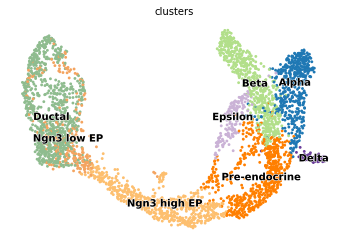

In [6]:
os.makedirs(figure_path_base, exist_ok=True)
scv.pl.scatter(adata, basis='umap', save=figure_path_base+"/umap.png")

Run scVelo and compute the velocity and latent time

In [7]:
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, vkey='velocity', mode='dynamical')
scv.tl.latent_time(adata)

recovering dynamics (using 1/32 cores)


  0%|          | 0/1263 [00:00<?, ?gene/s]

    finished (0:08:25) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


<br><br><br><br><br>
# Train a VeloVAE Basic Model
The basic model assumes fixed transcription rates. This serves as a baseline for our method. For those who just need to apply our method, please consider the complete model or full VB (examples shown in the later sections).
## Step 1: Define saving paths
We store the figures in "figure_path", model parameters in "model_path" and updated .h5ad file in data_path.

In [8]:
figure_path = figure_path_base+"/VanillaVAE"
model_path = model_path_base+"/VanillaVAE"
data_path = data_path_base

## Step 2: Create a Vanilla VAE object
Mandatory Arguments:
1. <b>adata</b>: anndata object
2. <b>tmax</b>: time range. We set it to 20 following the convention from scVelo.

Critical Arguments:
1. <b>device</b>: please set to the corresponding cuda device for training if possible.
2. <b>hidden_size</b>: a tuple, e.g. (500,250). The two numbers are width of the first and second hidden layers of the encoder network.
3. <b>init_method</b>: rate parameter initialization method. By default, the parameter is set to "steady", meaning the steady state model. However, if capture time is available, please consider setting it to "tprior", and the model will be initialized from a time series where the time is approximated by the capture time.
4. <b>init_key</b>: key in .obs storing the informative time prior. This is effective only if init_method is set to "tprior".
5. <b>tprior</b>: key in .obs storing the informative time prior. <b>This is usually the same key as "init_key", but has a different purpose. This key is used when we compute the KL divergence in ELBO, while "init_key" is used only in initialization.</b>

In [9]:
torch.manual_seed(2022)
np.random.seed(2022)

vanilla_vae = vv.VanillaVAE(adata, tmax=20, device='cuda:0')

Initialization using the steady-state and dynamical models.
Gaussian Prior.


## Step 3: Mini-batch training
Mandatory Arguments:
1. <b>adata</b>: anndata object

Critical Arguments:
1. <b>config</b>: a dictionary containing all hyperparameters. The keys are parameter names (string). Most default hyperparameters achieved consistent performance across different datasets. However, we recommend modifying the following hyperparameters in certain situations:<br>
(1) <b>batch_size</b>: set to 128 by default. However, for large datasets, we recommend increasing the batch size accordingly.<br>
(2) <b>early_stop</b>: set to 5 by default. This is the number of consecutive epochs when the validation loss decreases by less than some threshold (introduced in the next item), used in early stopping. <br>
(3) <b>early_stop_thred</b>: set to $n_{gene}\cdot 10^{-3}$ by default. This is the threshold used in early stopping.<br>

"config" will not be required if you just want the default, as shown in the following line of code.

In [10]:
vanilla_vae.train(adata, plot=True, gene_plot=gene_plot, figure_path=figure_path)

------------------------- Train a Vanilla VAE -------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
Total Number of Iterations Per Epoch: 21, test iteration: 40
Epoch 1: Train ELBO = -4308.928, Test ELBO = -4515.388, 	 Total Time =   0 h :  0 m :  2 s
Epoch 100: Train ELBO = -1928.274, Test ELBO = -1747.812, 	 Total Time =   0 h :  0 m : 23 s
Epoch 200: Train ELBO = 1249.834, Test ELBO = 1281.736, 	 Total Time =   0 h :  0 m : 44 s
Epoch 300: Train ELBO = 1339.453, Test ELBO = 1327.554, 	 Total Time =   0 h :  1 m :  5 s
********* Early Stop Triggered at epoch 364. *********
*********              Finished. Total Time =   0 h :  1 m : 17 s             ********

## Step 4: Save results

In [11]:
vanilla_vae.save_model(model_path, "encoder_vanilla","decoder_vanilla")
vanilla_vae.save_anndata(adata, 'vanilla', data_path, file_name="pancreas_out.h5ad")

<br><br><br><br><br>
# Train a VeloVAE Model
This is our full model. In addition to the blocks in the basic model, there is a decoder network producing variable transcription rates.

## Step 1: Define saving paths
We store the figures in "figure_path", model parameters in "model_path" and updated .h5ad file in data_path.

In [12]:
figure_path = figure_path_base+"/VAE"
model_path = model_path_base+"/VAE"
data_path = data_path_base

## Step 2: Create a VeloVAE object

Mandatory Arguments:
1. <b>adata</b>: anndata object
2. <b>tmax</b>: time range. We set it to 20 following the convention from scVelo.
3. <b>dim_z</b>: dimension of the cell state. Here, we use the variable "z" instead of "c" in the paper to follow the convention in the VAE literature.

Critical Arguments:
1. <b>device</b>: please set to the corresponding cuda device for training if possible.
2. <b>hidden_size</b>: a tuple, e.g. (500,250,250,500). The first two numbers are width of the first and second hidden layers of the encoder network. The third and fourth numbers are width of the first and second hidden layers of the decoder network. Our decoder network is usually a mirror image of the encoder.
3. <b>init_method</b>: rate parameter initialization method. By default, the parameter is set to "steady", meaning the steady state model. However, if capture time is available, please consider setting it to "tprior", and the model will be initialized from a time series where the time is approximated by the capture time.
4. <b>init_key</b>: key in .obs storing the informative time prior. This is effective only if init_method is set to "tprior".
5. <b>tprior</b>: key in .obs storing the informative time prior. <b>This is usually the same key as "init_key", but has a different purpose. This key is used when we compute the KL divergence in ELBO, while "init_key" is used only in initialization.</b>
6. <b>init_ton_zero</b>: set to True by default. If set to True, the switch-on time of each gene is 0. We recommend setting it to False if the capture time is available. We empirically found that it worked better.

In [13]:
torch.manual_seed(2022)
np.random.seed(2022)
vae = vv.VAE(adata, tmax=20, dim_z=5, device='cuda:0')

Initialization using the steady-state and dynamical models.
Gaussian Prior.


## Step 3: Mini-batch training
Mandatory Arguments:
1. <b>adata</b>: anndata object

Critical Arguments:
This will not be required if you just want the default, as shown in the following line of code.<br>
1. <b>config</b>: a dictionary containing all hyperparameters. The keys are parameter names (string). Most default hyperparameters achieved consistent performance across different datasets. However, we recommend modifying the following hyperparameters in certain situations:<br>
(1) <b>batch_size</b>: set to 128 by default. However, for large datasets, we recommend increasing the batch size accordingly.<br>
(2) <b>early_stop</b>: set to 5 by default. This is the number of consecutive epochs when the validation loss decreases by less than some threshold (introduced in the next item), used in early stopping. <br>
(3) <b>early_stop_thred</b>: set to $n_{gene}\cdot 10^{-3}$ by default. This is the threshold used in early stopping.<br>
(4) <b>n_neighbors</b>: set to 10 by default. This is the number of neighbors when we estimate the initial condition by averaging u,s in a time window.<br>
(5) <b>dt</b>: set to $(0.03,0.06)$ by default. This is used to pick the time window during recalculating the initial condition for each cell. For example, let $t$ be a cell time and $\Delta_t$ be the time range across all cells. Then the time window will be $[t-0.06\Delta_t, t-0.03\Delta_t]$

In [14]:
vae.train(adata, gene_plot=gene_plot, plot=True, figure_path=figure_path, embed="umap")

--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 21, test iteration: 40
Epoch 1: Train ELBO = -12205.863, Test ELBO = -223688.625, 	 Total Time =   0 h :  0 m :  1 s
Epoch 100: Train ELBO = 902.730, Test ELBO = 952.711, 	 Total Time =   0 h :  0 m : 26 s
Epoch 200: Train ELBO = 1643.758, Test ELBO = 1642.609, 	 Total Time =   0 h :  0 m : 50 s
Epoch 300: Train ELBO = 1908.095, Test ELBO = 1911.266, 	 Total Time =   0 h :  1 m : 14 s
Epoch 400: Train ELBO = 2048.954, Test ELBO = 2049.553, 	 Total Time =

## Step 4: Save results

In [15]:
vae.save_model(model_path, 'encoder_vae', 'decoder_vae')
vae.save_anndata(adata, 'vae', data_path, file_name="pancreas_out.h5ad")

<br><br><br><br><br>
# Train a VeloVAE (Full VB) Model
The full VB model is a slight extension of VeloVAE by treating the rate parameters as random variables. Model usage is the same as VeloVAE.
## Step 1: Define saving paths
We store the figures in "figure_path", model parameters in "model_path" and updated .h5ad file in data_path.

In [16]:
figure_path = figure_path_base+"/FullVB"
model_path = model_path_base+"/FullVB"
data_path = data_path_base

## Step 2: Create a full VB object
For input arguments, we refer to the module for VeloVAE.

In [17]:
torch.manual_seed(2022)
np.random.seed(2022)
full_vb = vv.VAEFullVB(adata, tmax=20, dim_z=5, device='cuda:0')

Initialization using the steady-state and dynamical models.
Gaussian Prior.


## Step 3: Mini-batch training
The only additional hyperparameter for the full VB is the KL coefficient of the rate parameters. It's set to 1.0 by default.<br>
All other input arguments and hyperparameters in config are the same as VeloVAE.

In [18]:
full_vb.train(adata, plot=True, gene_plot=gene_plot, figure_path=figure_path, embed="umap")

--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 21, test iteration: 40
Epoch 1: Train ELBO = -12276.206, Test ELBO = -223746.625, 	 Total Time =   0 h :  0 m :  1 s
Epoch 100: Train ELBO = 913.084, Test ELBO = 912.199, 	 Total Time =   0 h :  0 m : 28 s
Epoch 200: Train ELBO = 1605.756, Test ELBO = 1569.588, 	 Total Time =   0 h :  0 m : 55 s
Epoch 300: Train ELBO = 1882.161, Test ELBO = 1852.694, 	 Total Time =   0 h :  1 m : 22 s
Epoch 400: Train ELBO = 2028.177, Test ELBO = 1984.220, 	 Total Time =

## Step 4: Save results

In [19]:
full_vb.save_model(model_path, "encoder_fullvb","decoder_fullvb")
full_vb.save_anndata(adata, 'fullvb', data_path, file_name="pancreas_out.h5ad")

<br><br><br><br><br>
# (Optional) Train a Branching ODE Model
The branching ODE is a lumped-element model for VeloVAE. It treats each cell type separately and learns type-specific rate parameters. Please train VeloVAE or Full VB first before training this model.
## Step 1: Define saving paths
We store the figures in "figure_path", model parameters in "model_path" and updated .h5ad file in data_path.

In [20]:
figure_path = figure_path_base+"/BrODE"
model_path = model_path_base+"/BrODE"
data_path = data_path_base

## Step 2: Create an Branching ODE object
To create a Branching ODE object, we need to pass the following arguments:
1. AnnData object with trained parameters stored inside (via saveAnnData)
2. Key in .obs storing cell types, e.g. "clusters".
3. Key in .obs storing inferred cell time, e.g. "fullvb_time".
4. Key in .obsm storing inferred cell latent state, e.g. "fullvb_z".
5. (Optional) Parameters for transition graph computation. The transition graph is computed by first picking k nearest neighbors in a time window as the progenitor cells. Then, it computes the frequency of cell type transition and builds a weighted graph. Finally, it applies the Chu-Liu/Edmonds algorithm to find a maximum spanning tree. This parameter is a dictionary with three keys:

    (1) $dt$: a tuple of time window coefficient, e.g. (0.01, 0.05). In this example, for any cell with time t, its progenitor cell will be picked in the time window $[t-0.05\cdot \Delta_t, t-0.01\cdot \Delta_t]$, where $\Delta_t = t_{max}-t_{min}$
    
    (2)$k$: number of progenitor cells in the time window
    
    (3)n_par: number of potential parent cell type. This is used in graph pruning. Usually set to 2 or 3 to speed up computation.

In [21]:
torch.manual_seed(2022)
np.random.seed(2022)
brode = vv.BrODE(adata, "clusters", "fullvb_time", "fullvb_z", graph_param={"dt":(0.01,0.05), "k":5, "n_par":2})

Graph Partition
Number of partitions:  1
Computing type-to-type transition probability
Obtaining the MST in each partition
Initialization using type-specific dynamical model.


## Step 3: Mini-batch Training

In [22]:
brode.train(adata, "fullvb_time", "clusters", plot=True, gene_plot=gene_plot, figure_path=figure_path)

------------------------ Train a Branching ODE ------------------------
               Alpha  Beta  Delta  Ductal  Epsilon  Ngn3 high EP  Ngn3 low EP  Pre-endocrine
Alpha            0.0   0.0    0.0     0.0      0.0           0.0          0.0            1.0
Beta             0.0   0.0    0.0     0.0      0.0           0.0          0.0            1.0
Delta            0.0   0.0    0.0     0.0      0.0           0.0          0.0            1.0
Ductal           0.0   0.0    0.0     1.0      0.0           0.0          0.0            0.0
Epsilon          0.0   0.0    0.0     0.0      0.0           0.0          0.0            1.0
Ngn3 high EP     0.0   0.0    0.0     0.0      0.0           0.0          1.0            0.0
Ngn3 low EP      0.0   0.0    0.0     1.0      0.0           0.0          0.0            0.0
Pre-endocrine    0.0   0.0    0.0     0.0      0.0           1.0          0.0            0.0
*********        Creating Training/Validation Datasets        *********
*********          

## Step 4: Save results

In [23]:
brode.save_model(model_path, "brode")
brode.save_anndata(adata, 'brode', data_path, file_name="pancreas_out.h5ad")

<br><br><br><br><br>
# Post Analysis
## Compute the Metrics and Plot the Genes
Use the built-in analysis function of the velovae package <br>

Mandatory Arguments:
1. <b>adata</b>: anndata object
2. <b>test_id</b>: name of the test. Used for storing the figures.
3. <b>methods</b>: name of the methods. Should be a list containing one or multiple of the following: "scVelo", "Vanilla VAE", "VeloVAE", "Full VB".
4. <b>keys</b>: list of key names corresponding to each method. This is used to extract all relevant quantities (latent variables, rate parameters). For example, when we pick VeloVAE as the method, the corresponding key is "vae". The rate parameters are stored as "vae_alpha", "vae_beta", "vae_gamma" in .var. 

Critical Arguments:
1. <b>compute_metrics</b>: whether to compute the performance metrics. Should be set to False if you only want figures.
2. <b>genes</b>: genes to plot.
3. <b>plot_type</b>: list of plot type names. Should contain zero or more from the following: "phase", "signal", "time", "cluster".
4. <b>grid_size</b>: tuple, e.g. (M,N). The signal plot of genes will be in a single figure containing a grid of subplots. The grid has M rows and N columns.

In [24]:
methods = ['scVelo', 'Vanilla VAE', 'VeloVAE']
keys = ['fit', 'vanilla', 'vae']
grid_size = (1,2)
plot_type = ["phase","signal","time"]
vv.post_analysis(adata, 
                 test_id="pancreas",
                 methods=methods, 
                 keys=keys,
                 compute_metrics=True,
                 genes=gene_plot, 
                 plot_type=plot_type, 
                 embed="umap", 
                 grid_size=grid_size, 
                 save_path=figure_path_base)

---     Post Analysis     ---
Dataset Size: 3696 cells, 2000 genes
              scVelo  Vanilla VAE   VeloVAE
MSE Train     2.0184       6.8325    1.0969
MAE Train      0.395       0.3413    0.2021
MSE Test         N/A       6.1139    1.0774
MAE Test         N/A       0.3362    0.2010
LL Train  -1796.5218     502.7018  959.1023
LL Test          N/A     522.4360  967.2236
---   Plotting  Results   ---


,scVelo,Vanilla VAE,VeloVAE
MSE Train,2.0184,6.8325,1.0969
MAE Train,0.395,0.3413,0.2021
MSE Test,N/A,6.1139,1.0774
MAE Test,N/A,0.3362,0.2010
LL Train,-1796.5218,502.7018,959.1023
LL Test,N/A,522.4360,967.2236


## Cell Time and State Uncertainty
We can call plot_state_var and plot_time_var directly from the velovae.plotting module.

In [25]:
key = "fullvb"
basis = "umap"

In [26]:
std_z = adata.obsm[f"{key}_std_z"]
z = adata.obsm[f"{key}_z"]
X_embed = adata.obsm[f"X_{basis}"]
vv.plotting.plot_state_var(std_z, X_embed, z, save=f"figures/Pancreas/pancreas_state_var.png")

In [27]:
t = adata.obs["fullvb_time"].to_numpy()
std_t = adata.obs["fullvb_std_t"].to_numpy()
X_embed = adata.obsm[f"X_{basis}"]
vv.plotting.plot_time_var(std_t, X_embed, t, save=f"figures/Pancreas/pancreas_time_var.png")

## Other Results
The following plots are not part of the package and we show them here as supplementary results.

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap
z = adata.obsm[f'{key}_z']
t = adata.obs[f'{key}_time'].to_numpy()
rho = adata.layers[f'{key}_rho']

cell_labels = adata.obs['clusters'].to_numpy()
cell_types = np.unique(cell_labels)
colors = vv.plotting.get_colors(len(cell_types))

## Result 1: Transcription Rate $\rho$

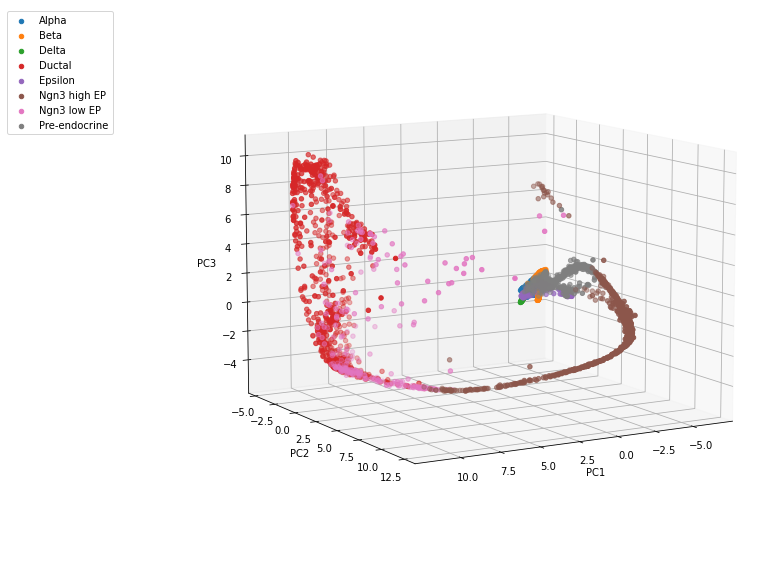

In [29]:
pca = PCA(n_components=3)
rho_pca = pca.fit_transform(rho)

fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.view_init(10, 60)
for i,x in enumerate((cell_types)):
    ax.scatter(rho_pca[cell_labels==x,0], rho_pca[cell_labels==x,1], rho_pca[cell_labels==x,2], label=x, color=colors[i])
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(figure_path_base+'/rho_pca.png')

## Result 2: Latent Embedding

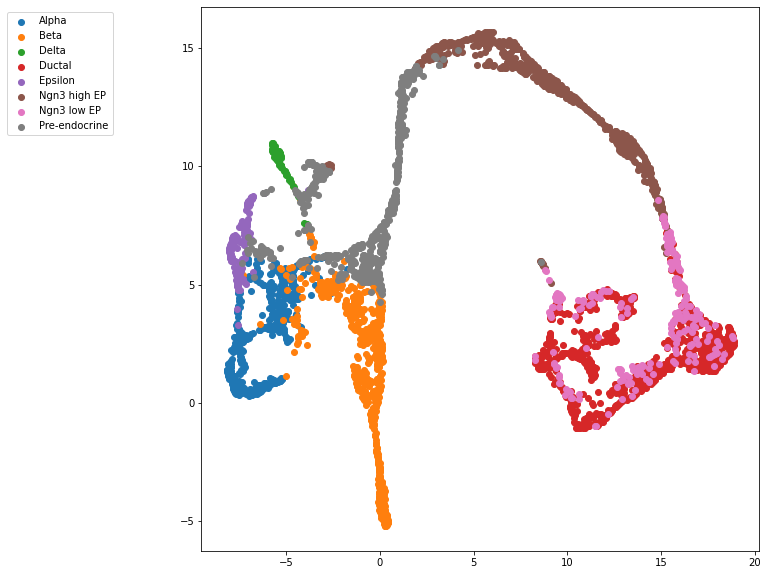

In [30]:
umap_obj = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.25)
z_umap = umap_obj.fit_transform(z)

fig=plt.figure(figsize=(10,10))
for i,x in enumerate((cell_types)):
    plt.scatter(z_umap[cell_labels==x,0], z_umap[cell_labels==x,1], label=x, color=colors[i])
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')
plt.show()
fig.savefig(figure_path_base+'/z_umap.png')

## Result 3: Velocity Stream Plot

computing velocity graph (using 1/32 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file figures/Pancreas/Pancreas_velocity_scv.png


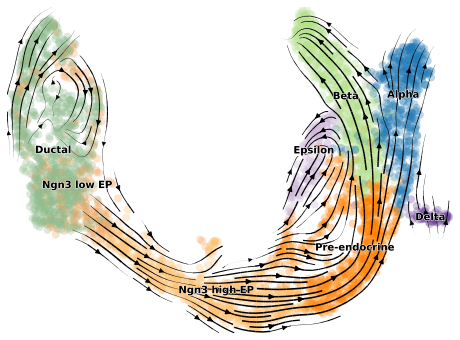

In [31]:
import scvelo as scv
scv.tl.velocity_graph(adata, vkey='velocity')
scv.tl.velocity_embedding(adata, vkey='velocity')
scv.pl.velocity_embedding_stream(adata, vkey='velocity', figsize=(8,6), title="", save=f'{figure_path_base}/{dataset}_velocity_scv.png')

computing velocity graph (using 1/32 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:28) --> added 
    'vanilla_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vanilla_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file figures/Pancreas/Pancreas_velocity_vanilla.png


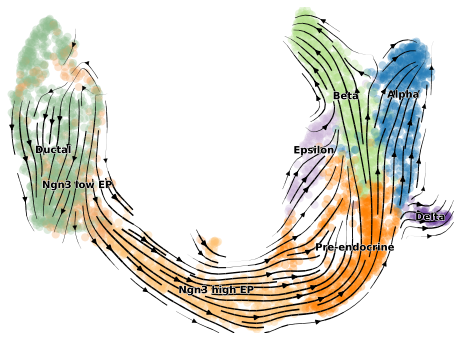

In [32]:
key = 'vanilla'
scv.tl.velocity_graph(adata, vkey=f'{key}_velocity')
scv.tl.velocity_embedding(adata, vkey=f'{key}_velocity')
scv.pl.velocity_embedding_stream(adata, vkey=f'{key}_velocity', title="", figsize=(8,6), save=f'{figure_path_base}/{dataset}_velocity_{key}.png')

computing velocity graph (using 1/32 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:28) --> added 
    'fullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'fullvb_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file figures/Pancreas/Pancreas_velocity_fullvb.png


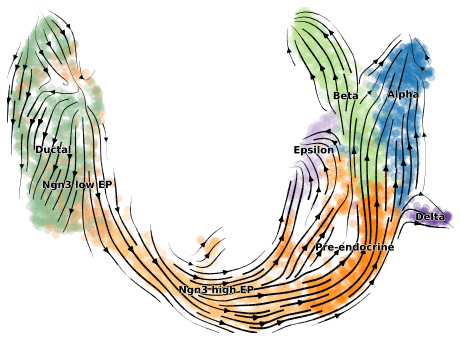

In [33]:
key = 'fullvb'
scv.tl.velocity_graph(adata, vkey=f'{key}_velocity')
scv.tl.velocity_embedding(adata, vkey=f'{key}_velocity')
scv.pl.velocity_embedding_stream(adata, vkey=f'{key}_velocity', title="", figsize=(8,6), save=f'{figure_path_base}/{dataset}_velocity_{key}.png')

In [34]:
adata.write_h5ad(data_path_base+"/pancreas_out.h5ad")